# MNIST Embeddings

## Imports and Hyper-parameters 

In [1]:
import torch 
import os 
import numpy as np 
from torchvision import transforms 
from torchvision.datasets import MNIST 
from torchvision import models 
from itertools import combinations

print(os.getcwd())
root = os.getcwd()

from DeepFeatures import DeepFeatures
from mnist_net import Net

/home/praveens/Desktop/synthetic_biometrics/visualize_embeddings


In [2]:
batch_size = 128
data_folder = root + '/MNIST'
device = 'cpu'
model_path = './mnist_net.pth'

merge_class1 = 1
merge_class2 = 4

## Create Dataloader

In [3]:
transformations = transforms.Compose([transforms.Resize((221, 221)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485], std=[0.229])
                                    ])

mnist_data = MNIST(root=r'./MNIST',
                   download=False, train=False,
                   transform=transformations)

data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True)

In [4]:
# list(mnist_net.named_parameters())

## Initialize Tensorboard Logging Class 

In [4]:
mnist_net = Net().to(device)
mnist_net.load_state_dict(torch.load(model_path))  # load saved model 

mnist_net.eval()

Net(
  (conv1): Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (fc4): Linear(in_features=3, out_features=3, bias=True)
  (fc5): Linear(in_features=3, out_features=10, bias=True)
)

In [5]:
deep_features = DeepFeatures(model=mnist_net)

In [6]:
batch_images, batch_labels = next(iter(data_loader))

In [9]:
embeds = deep_features.generate_embeddings(batch_images)
embeds = embeds.detach().cpu().numpy()

In [26]:
X, Y, Z = embeds.T
X, Y, Z = X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1)

In [27]:
X.shape

(128, 1)

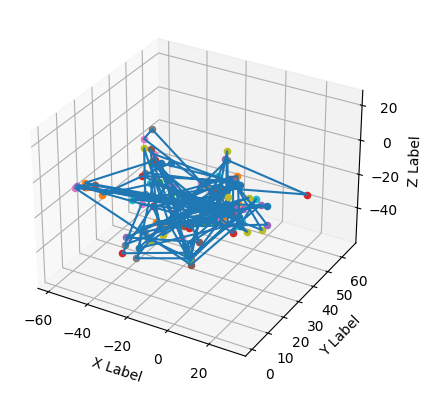

In [29]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Grab some example data and plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

# Set the axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for xs, ys, zs in zip(X, Y, Z): 
    ax.scatter(xs, ys, zs)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [7]:
def find_class_embeddings(deep_features, data_loader, class1, class2):
    images, labels = next(iter(data_loader))
    e = deep_features.generate_embeddings(images).clone().detach()
    
    x1 = None
    class1 = torch.tensor(class1)
    class1_count = 0

    x2 = None
    class2 = torch.tensor(class2)
    class2_count = 0

    for index, (image, label) in enumerate(zip(images, labels)):
        if class1_count == 1 and class2_count == 1:
            break 
        
        if (not class1_count) and label == class1:
            x1 = e[index]/torch.norm(e[index])
            class1_count += 1
        if (not class2_count) and label == class2:
            x2 = e[index]/torch.norm(e[index])
            class2_count += 1
    
    print('val of class ' + str(class1.numpy()) + ' : ', x1)
    print('val of class '  + str(class2.numpy()) + ' : ', x2)
    print('cosine similarity : ', (np.dot(x1, x2)/np.linalg.norm(x1)*np.linalg.norm(x2)))
    
    return x1, x2

In [8]:
x1, x2 = find_class_embeddings(deep_features, data_loader, merge_class1, merge_class2)
x1, x2

val of class 1 :  tensor([ 0.3052,  0.1725, -0.9365])
val of class 4 :  tensor([-0.9101,  0.3809, -0.1629])
cosine similarity :  -0.059480563


(tensor([ 0.3052,  0.1725, -0.9365]), tensor([-0.9101,  0.3809, -0.1629]))

In [9]:
def change_of_basis(wm, d):
    combs = [list(range(wm.shape[1]-1)), 
             list(range(1, wm.shape[1]))]
    
    max_det = 0
    new_wm = None 

    for c in combs:
        curr_det = np.linalg.det(np.column_stack((d, wm[:, c])))
        print('det : ', curr_det)
        if abs(curr_det) > abs(max_det):
            max_det = curr_det
            new_wm = np.column_stack((d, wm[:, c]))

    return torch.tensor(new_wm)

In [10]:
def perform_weight_surgery(mnist_net, x1, x2, save_model=True):
    
    # calculate the difference between the 2 class vectors 
    d = (x2/torch.norm(x2)) - (x1/torch.norm(x1))  
    print('d : ', d)
    print('normed d : ', d/torch.norm(d))
    weight_matrix = mnist_net.fc4.weight.clone().detach()  # weight matrix of the penultimate layer 
    print('weight matrix : \n', weight_matrix)
    
    new_wm = change_of_basis(weight_matrix, d)
    print('new weight matrix : \n', new_wm)
    
    def gram_schmidt(weight_matrix):
        new_basis_vectors = [weight_matrix[:, 0]]
        m, n = weight_matrix.shape

        for i in range(1, n):

            a_i = weight_matrix[:, i].clone()
            q_i = 0

            for j, q_j in enumerate(new_basis_vectors):
                q_i -= (torch.dot(q_j, a_i) * q_j)
            
            q_i += a_i
            q_i = q_i / torch.norm(q_i)
            
#             if check_if_orthogonal(new_basis_vectors, q_i):
            new_basis_vectors.append(q_i)
            
        return new_basis_vectors
    
    
    new_basis_vectors = gram_schmidt(new_wm)
    
    U = [nbv.reshape(-1, 1) for nbv in new_basis_vectors]
    U = torch.cat(U, axis=1)
#     U, _ = torch.qr(new_wm)
    print('unitary matrix :\n', U)
#     print('QR decomp :\n', Q)
    
    S = torch.eye(U.shape[0])
    S[0, 0] = 0
    print('projection matrix :\n', S)
    
    print('modified weight matrix :\n', weight_matrix @ U @ S @ U.T)
    
    mnist_net.fc4.weight = torch.nn.Parameter(weight_matrix @ U @ S @ U.T)
    
    if save_model: 
        path = './modified_mnist_net.pth'
        torch.save(mnist_net.state_dict(), path)

In [11]:
perform_weight_surgery(mnist_net, x1, x2, save_model=True)

d :  tensor([-1.2153,  0.2084,  0.7736])
normed d :  tensor([-0.8349,  0.1432,  0.5315])
weight matrix : 
 tensor([[ 0.3257, -1.0893,  0.8606],
        [ 0.0483,  0.1397,  0.5508],
        [-1.0913,  0.2588,  0.4324]])
det :  0.10562828
det :  -0.31283915
new weight matrix : 
 tensor([[-1.2153, -1.0893,  0.8606],
        [ 0.2084,  0.1397,  0.5508],
        [ 0.7736,  0.2588,  0.4324]])
unitary matrix :
 tensor([[-1.2153,  0.6391,  0.0364],
        [ 0.2084, -0.1473,  0.5704],
        [ 0.7736, -0.7548,  0.8206]])
projection matrix :
 tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
modified weight matrix :
 tensor([[-0.1761,  0.0966,  0.2915],
        [-0.2397,  0.3640,  0.7438],
        [-0.6619,  0.4203,  1.1813]])


In [12]:
original_mnist_net = Net().to(device)
original_mnist_net.load_state_dict(torch.load('./mnist_net.pth'))  # load saved model 

original_mnist_net.eval()

original_deep_features = DeepFeatures(model=original_mnist_net)

In [13]:
_, _ = find_class_embeddings(original_deep_features, data_loader, merge_class1, merge_class2)

val of class 1 :  tensor([ 0.2798,  0.0558, -0.9584])
val of class 4 :  tensor([-0.9841,  0.1583, -0.0800])
cosine similarity :  -0.18986736


In [14]:
_, _ = find_class_embeddings(deep_features, data_loader, merge_class1, merge_class2)

val of class 1 :  tensor([-0.2294, -0.2959, -0.9272])
val of class 4 :  tensor([0.0755, 0.8928, 0.4441])
cosine similarity :  -0.6933615


## Write Modified Embeddings to Tensorboard

In [15]:
deep_features.create_tensorboard_dirs()

In [16]:
batch_images, batch_labels = next(iter(data_loader))
deep_features.write_embeddings(x=batch_images.to(device))

True

In [17]:
deep_features.create_tensorboard_log()

torch.Size([128, 3])
torch.Size([128, 1, 28, 28])


/home/praveens/Desktop/synthetic_biometrics/visualize_embeddings/DeepFeatures.py:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/builder/mc3/envs/pytorch-build/envs/pytorch-build/conda-bld/pytorch_1673601922403/work/torch/csrc/utils/tensor_new.cpp:201.)
  all_embeds = torch.Tensor(all_embeds)


## Write Unmodified Embeddings to Tensorboard

In [18]:
original_deep_features.create_tensorboard_dirs(model_type='original')

In [19]:
batch_images, batch_labels = next(iter(data_loader))
original_deep_features.write_embeddings(x=batch_images.to(device))

True

In [20]:
original_deep_features.create_tensorboard_log()

torch.Size([128, 3])
torch.Size([128, 1, 28, 28])


## Accuracy over test images

In [21]:
def accuracy_over_test_images(mnist_net):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device); labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = mnist_net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the '+ str(total) +' test images: '+ str(100 * correct // total)+ '%')

In [22]:
accuracy_over_test_images(mnist_net)

Accuracy of the network on the 10000 test images: 22%


In [23]:
accuracy_over_test_images(original_mnist_net)

Accuracy of the network on the 10000 test images: 96%


In [24]:
# 1, 0 split (accuracy 45%)
# 1, 2 split (accuracy 47%)
# 1, 3 split (accuracy 46%)
# 1, 4 split (accuracy 36%)
# 1, 5 split (accuracy 39%)
# 1, 6 split (accuracy 52%) had to run twice 
# 1, 7 split (accuracy Not Possible %)
# 1, 8 split (accuracy  Not possible %)
# 1, 9 split (accuracy  37%)